# Market Trend Analysis Using Exponential Smoothing and Prophet

In this project, we applied two popular time series forecasting methods, Exponential Smoothing and Prophet, to analyze stock market trends.

This project highlights the importance of choosing the right forecasting models for stock market trend analysis. Both Exponential Smoothing and Prophet are useful tools that can help analysts and investors gain a better understanding of market behavior, predict future price movements, and ultimately make informed decisions.

## Load Data

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet 
import matplotlib.pyplot as plt

## Inspecting Data

In [2]:
# Load data from ZIP
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    file_list = z.namelist()  # List all files (e.g., ['A.csv', 'AAL.csv', ...])
    
    # Load first 3 files as samples for inspection
    sample_data = {f: pd.read_csv(z.open(f)) for f in file_list[:3]}

# Inspect a sample file (e.g., A.csv)
print("Sample Data Structure:")
print(sample_data['A.csv'].head())
print("\nMetadata:")
print(sample_data['A.csv'].info())
print("\nMissing Values:")
print(sample_data['A.csv'].isnull().sum())
print("\nMissing Values:")
print(sample_data['A.csv'].describe())

Sample Data Structure:
  Ticker        Date       Open       High        Low      Close  Adj Close  \
0      A  1999-11-18  32.546494  35.765381  28.612303  31.473534  26.794758   
1      A  1999-11-19  30.713518  30.758226  28.478184  28.880545  24.587236   
2      A  1999-11-22  29.551144  31.473534  28.657009  31.473534  26.794758   
3      A  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.358873   
4      A  1999-11-24  28.701717  29.998213  28.612303  29.372318  25.005903   

     Volume  
0  62546380  
1  15234146  
2   6577870  
3   5975611  
4   4843231  

Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     5964 non-null   object 
 1   Date       5964 non-null   object 
 2   Open       5964 non-null   float64
 3   High       5964 non-null   float64
 4   Low        5964 non-null   float64
 5   Close      5964 

## Visualizing Stock Data

The adjusted close prices for the first stock (AAPL in this case) are plotted over time to visualize the historical trend.

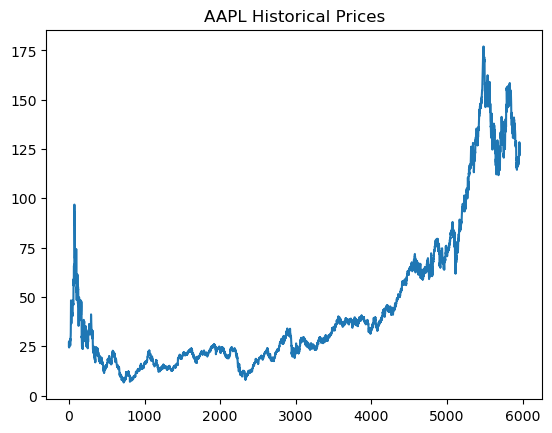

In [3]:
# Visualize a sample stock
sample_data['A.csv']['Adj Close'].plot(title='AAPL Historical Prices')
plt.show()

## Data Cleaning

This includes:

- Date Validation: Ensures the Date column is in datetime format, removing any invalid dates.
- Duplicate Handling: Removes rows with duplicate dates for the same ticker, keeping the most recent entry.
- Price Validation: Ensures price columns (Open, High, Low, Close, Adjusted Close) are numeric and checks for price consistency (e.g., High should not be lower than Low).
- Negative and Zero Prices: Removes rows where any of the price columns contain zero or negative values.
- Volume Validation: Ensures that the Volume column is numeric and non-negative.
- Date Sorting: Ensures the data is sorted chronologically.
- Daily Return Calculation: Adds a Daily_Return column that calculates the daily percentage change in adjusted close prices.

In [4]:
def clean_stock_data(df):
    """Enhanced cleaning for S&P 500 stock data"""
    
    # Convert and validate dates
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notna()]  # Remove rows with invalid dates
    
    # Handle duplicates (same ticker + date)
    df = df.drop_duplicates(subset=['Ticker', 'Date'], keep='last')
    
    # Validate price columns (OHLC)
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df[price_cols] = df[price_cols].apply(pd.to_numeric, errors='coerce')
    
    # Price consistency checks
    df = df[
        (df['High'] >= df[['Open', 'Low', 'Close']].max(axis=1)) &
        (df['Low'] <= df[['Open', 'High', 'Close']].min(axis=1))
    ]
    
    # Handle zero/negative prices
    df = df[(df[price_cols] > 0).all(axis=1)]
    
    # Volume validation
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df = df[df['Volume'] >= 0]
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Calculate returns for later analysis
    df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()
    
    return df

# Loading and Cleaning All Data

cleaned_data = {}
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    for file in z.namelist():
        ticker = file.split('.')[0]
        df = pd.read_csv(z.open(file))
        cleaned_data[ticker] = clean_stock_data(df)

# Validate cleaning
print(f"Cleaned {len(cleaned_data)} stocks")
aapl_stats = cleaned_data['A'].describe()
print(aapl_stats[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

Cleaned 503 stocks
              Open         High          Low        Close    Adj Close  \
count  5964.000000  5964.000000  5964.000000  5964.000000  5964.000000   
mean     47.395558    47.994878    46.788997    47.404786    44.782612   
min       7.653791     7.961373     7.510730     7.761087     6.607346   
25%      22.314020    22.644850    21.988556    22.301501    19.657610   
50%      31.491416    31.918813    31.030043    31.473534    28.291619   
75%      63.954999    64.969999    63.098973    64.112501    60.977356   
max     179.279999   179.570007   177.169998   179.279999   177.025650   
std      38.061525    38.440381    37.637164    38.044148    38.369622   

             Volume  
count  5.964000e+03  
mean   3.408797e+06  
min    2.719000e+05  
25%    1.900525e+06  
50%    2.904974e+06  
75%    4.245481e+06  
max    6.254638e+07  
std    2.421346e+06  


## Selecting Stock Data

In [ ]:
# Select a stock (e.g., AAL)
stock_data = cleaned_data['AAL'].copy()

## Exponential Smoothing

This section applies Holt-Winters Exponential Smoothing (HW) to the 'Close' price column.

Forecasts the next 30 days of stock prices using the trained Holt-Winters model.

In [ ]:
# Additive model with 252 trading days/year seasonality
hw_model = ExponentialSmoothing(
    stock_data['Close'],
    trend='add',
    seasonal='add',
    seasonal_periods=252,  # Trading days in a year
    initialization_method='estimated'
).fit()

# Forecast next 30 days
hw_forecast = hw_model.forecast(30)

## Prophet Model

The Prophet model is then trained using the historical stock data.

In [ ]:
# Prepare data (Prophet requires specific column names)
prophet_df = stock_data.reset_index()[['Date', 'Close']].rename(
    columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit with built-in holidays
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Stocks trade daily
    daily_seasonality=False,
    changepoint_prior_scale=0.05  # More flexible trend
).add_country_holidays(country_name='US')  # Add US market holidays
model_prophet.fit(prophet_df)

# Create future dataframe (30 days)
future = model_prophet.make_future_dataframe(periods=30, freq='D')
prophet_forecast = model_prophet.predict(future)

## Visualization

This sets up a figure with two subplots, allowing the two models' results to be plotted in one figure, with one plot for Holt-Winters and another for Prophet.

C:\Users\milto\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
15:32:47 - cmdstanpy - INFO - Chain [1] start processing
15:32:48 - cmdstanpy - INFO - Chain [1] done processing


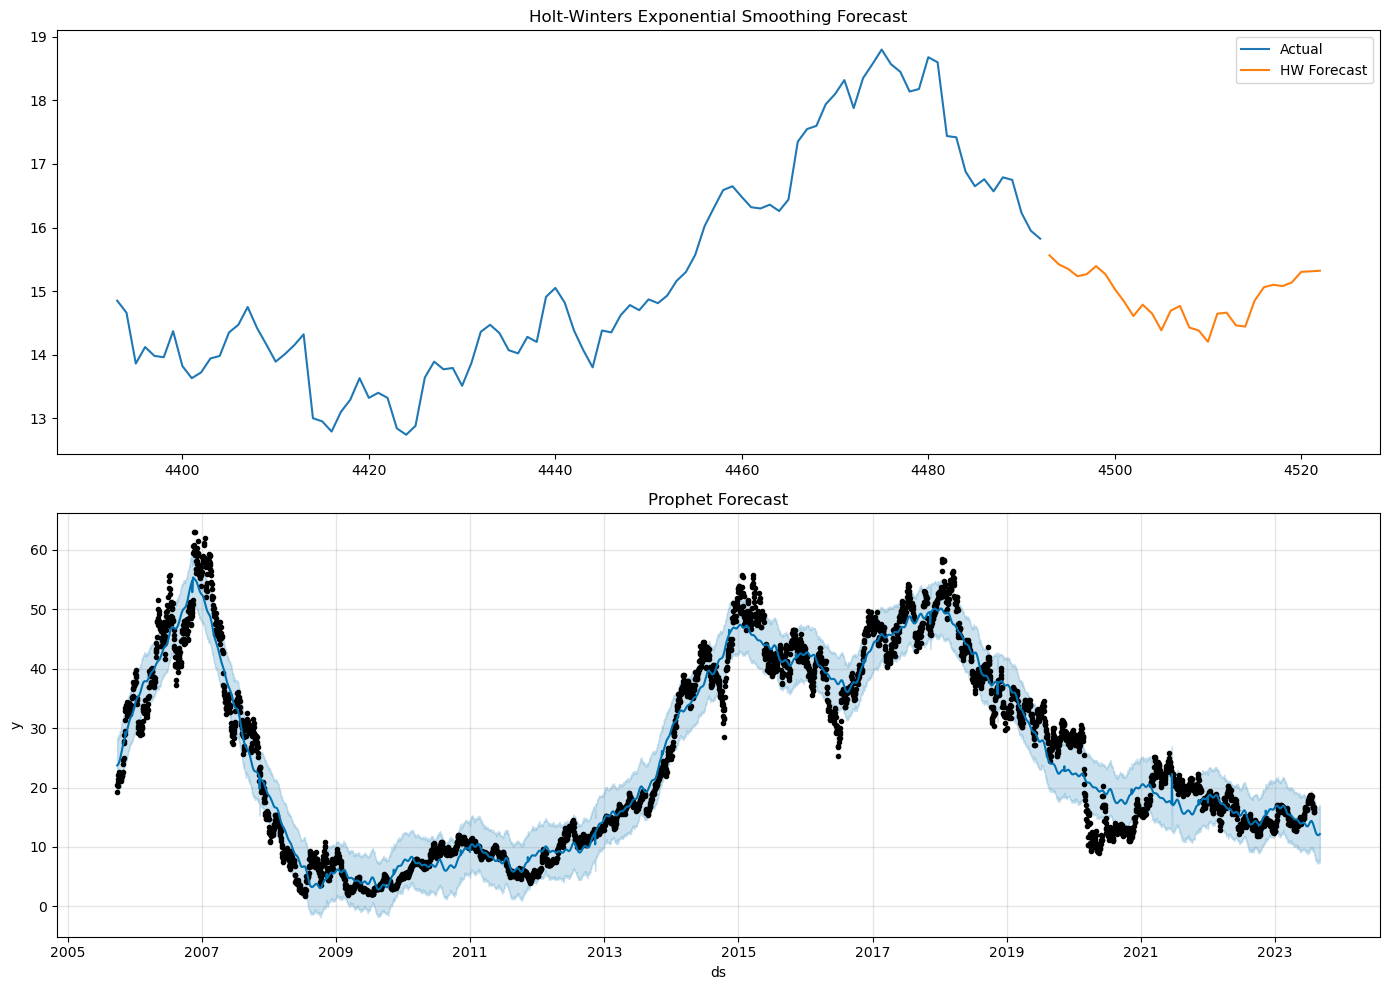

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Holt-Winters plot
stock_data['Close'].iloc[-100:].plot(ax=ax1, label='Actual')
hw_forecast.plot(ax=ax1, label='HW Forecast')
ax1.set_title('Holt-Winters Exponential Smoothing Forecast')
ax1.legend()

# Prophet plot
model_prophet.plot(prophet_forecast, ax=ax2)
ax2.set_title('Prophet Forecast')
plt.tight_layout()
plt.show()

## Summary

- Holt-Winters Exponential Smoothing is applied to forecast future stock prices, assuming both trend and seasonality in the stock data.
- Prophet is used to model stock prices with additional considerations for holidays and more flexible trend changes.
- Both models are visualized on separate plots, comparing the actual stock prices with their respective forecasts.

### Market Trend Analysis
- Holt-Winters Model: Identifies short-term trends based on the assumption of seasonality and a linear trend, which could help identify recurring cycles within the stock price.
- Prophet Model: Takes into account holidays and is more flexible with trend changes, which may be useful for analyzing longer-term market trends and sudden shifts.

Both methods are useful tools for market trend analysis as they highlight potential patterns, seasonality, and changes in stock prices.

## Conclusion

In this project, we applied two popular time series forecasting methods, Exponential Smoothing and Prophet, to analyze stock market trends. By leveraging these models, we aimed to identify recurring patterns, seasonal effects, and overall market trends within the stock data.

1. Exponential Smoothing: The Holt-Winters model was employed to capture the underlying trend and seasonality in the stock price data. This approach helped us understand how market fluctuations, such as yearly trading cycles, could influence stock behavior. The additive seasonal and trend components made it effective in capturing the smooth, gradual changes in stock prices.

2. Prophet: This model provided a more flexible and robust forecasting method, accounting for holidays and varying trends in stock prices. By incorporating these external factors, Prophet was able to better adapt to the complex nature of stock market data, including sudden shifts and longer-term trends. Additionally, its flexibility in modeling changepoints and seasonalities made it suitable for forecasting in the financial market.

Both models provided valuable insights into potential market trends and can be used to guide investment decisions and forecasting strategies. While Exponential Smoothing offered a simple yet effective approach for detecting seasonality, Prophet demonstrated its strength in handling more complex patterns, including external influences like holidays and abrupt trend changes.